In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cFeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

## Definitions of climate indices

The definitions of these climate indices are taken from Defrance (2019). 

Defrance, D. (2019). Dataset of global extreme climatic indices due to an acceleration of ice sheet melting during the 21st century. Data in brief, 27, 104585. https://doi.org/10.1016/j.dib.2019.104585 

In [4]:
def TNmin(da):
    # Calculate annual minimum temperature
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_minimum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TNmin = min(da_i.values)

                annual_minimum_temperatures[lat, lon, year] = TNmin - 273.15
    
    return annual_minimum_temperatures



def TXmax(da):
    # Calculate annual maximum temperature
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_maximum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TXmax = max(da_i.values)

                annual_maximum_temperatures[lat, lon, year] = TXmax - 273.15
    
    return annual_maximum_temperatures

def FD(da):
    # Calculate number of frost days
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_frost_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                FD = int(np.sum(da_i.values < 273.15))
                n_frost_days[lat, lon, year] = FD
    
    return n_frost_days

def ID(da):
    # Calculate number of icing days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_icing_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                ID = int(np.sum(da_i.values < 273.15))
                n_icing_days[lat, lon, year] = ID
    
    return n_icing_days

def TR(da):
    # Calculate number of tropical nights
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_tropical_nights = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TR = int(np.sum(da_i.values > 293.15)) # Sum days with minimum temperature larger than 20 deg Celsius
                n_tropical_nights[lat, lon, year] = TR
    
    return n_tropical_nights

def SU(da):
    # Calculate number of summer days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_summer_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                SU = int(np.sum(da_i.values > 298.15)) # Sum days with maximum temperature larger than 25 degrees Celsius
                n_summer_days[lat, lon, year] = SU
    
    return n_summer_days

def WSDI(da, TXin90):
    # Calculate well spell duration index
    # Input: daily maximum temperature and 90th percentile historical maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    warm_spell_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TXin90_i = TXin90[lat, lon, :]
                non_warm_days = [temp < threshold for temp, threshold in zip(da_i.values, TXin90_i)]
                non_warm_days_idx = np.where(non_warm_days)[0]
                WSDI = int(np.sum(np.diff(non_warm_days_idx) >= time_threshold))
                warm_spell_duration_index[lat, lon, year] = WSDI
    
    return warm_spell_duration_index

def CWDI(da, TNin10):
    # Calculate cold wave duration index
    # Input: daily minimum temperature and 10th percentile historical minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    cold_wave_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TNin10_i = TNin10[lat, lon, :]
                non_cold_days = [temp > threshold for temp, threshold in zip(da_i.values, TNin10_i)]
                non_cold_days_idx = np.where(non_cold_days)[0]
                CWDI = int(np.sum(np.diff(non_cold_days_idx) >= time_threshold))
                cold_wave_duration_index[lat, lon, year] = CWDI
    
    return cold_wave_duration_index


## Loading relevant climate variables from different models, areas and time periods

CMIP6 data downloaded from https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/

In [ ]:
# User input: define dataset specifics

model_scenario_name = 'MPI-ESM1-2-LR_ssp245' # Choose a model and SSP scenario
downscaled = True
area_name = 'norway' # Choose an area
save_folder = '../climatic_indices/' # Folder where climate indices should be saved

if downscaled==True:
    data_folder = '../NASA_data/' # Folder where downloaded downscaled CMIP6 data is stored
else:
    data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored

os.makedirs(save_folder, exist_ok=True) 

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'NorESM2-LM_ssp245':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'MRI-ESM2-0_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'MPI-ESM1-2-LR_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    cooling_year = '2040-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'GFDL-ESM4_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    cooling_year = '2040-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'europe':
    southern_lat = 35; northern_lat = 72
    western_lon = 310; eastern_lon = 33  
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")


# Load maximum daily temperature data

files = glob.glob(data_folder+'tasmax_day_'+model_scenario_name+'*')
files.sort()
tasmax = xr.open_mfdataset(files)

if area_name == 'europe':
    tmax1 = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, 360), 
                        time=slice(start_time, end_time))
    tmax2 = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(0, eastern_lon), 
                        time=slice(start_time, end_time))

    tmax = xr.concat([tmax1, tmax2], dim='lon')
else:
    tmax = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))
tmax.load()

# Load minimum daily temperature data

files = glob.glob(data_folder+'tasmin_day_'+model_scenario_name+'*')
files.sort()
tasmin = xr.open_mfdataset(files)

if area_name == 'europe':
    tmin1 = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, 360), 
                        time=slice(start_time, end_time))
    tmin2 = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(0, eastern_lon), 
                        time=slice(start_time, end_time))

    tmin = xr.concat([tmin1, tmin2], dim='lon')
else:
    tmin = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmin.load()
print('Temperature data loaded')


<xarray.DataArray 'tasmin' (time: 14611, lat: 8, lon: 9)> Size: 4MB
array([[[271.95364, 269.4701 , 264.3995 , ..., 268.70386, 269.82382,
         270.95288],
        [271.93015, 271.82916, 268.8221 , ..., 267.92236, 268.37152,
         270.14944],
        [269.78418, 271.1148 , 272.20078, ..., 271.71133, 271.80493,
         271.5908 ],
        ...,
        [274.47025, 273.81064, 273.50922, ..., 273.83264, 274.58502,
         275.33658],
        [277.41144, 276.3028 , 275.61816, ..., 274.91074, 275.18164,
         275.58453],
        [279.08847, 278.39954, 277.44635, ..., 276.5634 , 276.76846,
         277.0302 ]],

       [[272.5071 , 270.93256, 265.9203 , ..., 267.90558, 267.6236 ,
         269.2431 ],
        [271.8001 , 272.18185, 271.64648, ..., 264.45334, 266.14423,
         268.58392],
        [269.92303, 271.82022, 272.2106 , ..., 271.2768 , 271.37408,
         271.36133],
...
        [280.65744, 279.7248 , 279.39206, ..., 278.27206, 276.29956,
         274.5277 ],
        [281.61978, 280.92224, 280.66406, ..., 275.25253, 274.13385,
         273.6693 ],
        [281.9525 , 281.12878, 279.59354, ..., 275.92258, 275.6708 ,
         276.32135]],

       [[276.94418, 274.12753, 272.98178, ..., 273.0168 , 273.71582,
         274.59863],
        [279.13626, 277.00638, 275.988  , ..., 271.68607, 272.61893,
         274.41342],
        [278.0606 , 278.77795, 277.47345, ..., 275.7885 , 275.0838 ,
         275.3524 ],
        ...,
        [281.83304, 280.22556, 279.4246 , ..., 279.49222, 279.6313 ,
         278.3385 ],
        [282.37506, 281.4057 , 280.6554 , ..., 280.1725 , 280.39374,
         280.0162 ],
        [282.5719 , 281.9642 , 281.1316 , ..., 280.1    , 280.22705,
         280.51276]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 117kB 2020-01-01T12:00:00 ... 2060-01-01T1...
  * lat      (lat) float64 64B 46.54 47.66 48.78 49.91 51.03 52.15 53.27 54.39
  * lon      (lon) float64 72B 5.625 6.75 7.875 9.0 10.12 11.25 12.38 13.5 14.62
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TA
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-05-23T15:45:54Z altered by CMOR: Treated scalar dime...

## Calculate climatic indices

In [ ]:
# Choose which variable to calculate

variable_name_list = ['TNmin', 'TXmax', 'FD', 'ID', 'TR', 'SU']
unit_list = ['Celsius', 'Celsius', 'days', 'days', 'days', 'days']
description_list = ['Annual minimum temperature', 'Annual maximum temperature', 
                    'Number of frost days', 'Number of icing days', 
                    'Number of tropical nights', 'Number of summer days']

input_values_list = [tmin, tmax, tmin, tmax, tmin, tmax]
index_function_list = [TNmin, TXmax, FD, ID, TR, SU]


input_values_list = [tmin, tmin, tmin]
index_function_list = [TNmin, FD, TR,]

# Save data as netcdf file

for variable_name, unit, description, input_values, index_function in zip(variable_name_list, unit_list, description_list, input_values_list, index_function_list):
    print(variable_name)
    values = index_function(input_values)
    
    ds = xr.Dataset(
        data_vars=dict(
            variable=(["lat", "lon", "time"], values)
        ),
        coords=dict(
            lat=input_values.lat.values,
            lon=input_values.lon.values,
            time=time_array,
        ),
    )

    ds.time.attrs['units'] = 'year'
    ds.lat.attrs['description'] = 'latitude'
    ds.lon.attrs['description'] = 'longitude'
    ds = ds.rename_vars(dict(variable=variable_name))
    ds[variable_name].attrs['units'] = unit
    ds[variable_name].attrs['description'] = description

    ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
    print('Dataset saved')

TNmin
Dataset saved
FD
Dataset saved
TR
Dataset saved


## Calculate historical temperature distribution

In [8]:
# Define dataset specifics

model_name = model_scenario_name.split('_')[0] # Choose a model and SSP scenario

if not model_name == 'NorESM2-LM' or model_name == 'CESM2-WACCM' or model_name == 'MRI-ESM2':
    print("This dataset is not considered in the current study, but can be added to the analysis")

# Define reference period
start_time = '1976-01-01'; end_time = '2006-01-01'

# Load maximum daily temperature data from historical period

files = glob.glob(data_folder+'tasmax_day_'+model_name+'_historical*')
files.sort()
tasmax_hist = xr.open_mfdataset(files)

tmax_hist = tasmax_hist.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))
tmax_hist.load()

# Load minimum daily temperature data

files = glob.glob(data_folder+'tasmin_day_'+model_name+'_historical*')
files.sort()
tasmin_hist = xr.open_mfdataset(files)

tmin_hist = tasmin_hist.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmin_hist.load()

<xarray.DataArray 'tasmin' (time: 10951, lat: 4, lon: 5)> Size: 876kB
array([[[266.12714, 263.44846, 261.42117, 262.82523, 263.0375 ],
        [264.4767 , 262.0497 , 258.30902, 258.3632 , 257.99026],
        [265.5726 , 257.90106, 253.98329, 254.04227, 254.72964],
        [273.2214 , 267.58066, 259.41238, 263.8685 , 264.88284]],

       [[267.03336, 262.91354, 258.89868, 256.75177, 257.4733 ],
        [269.3177 , 264.8548 , 259.82996, 258.1787 , 257.5555 ],
        [272.82053, 271.49884, 265.81042, 259.2071 , 257.15002],
        [277.0136 , 273.2843 , 271.32608, 271.8972 , 271.65048]],

       [[267.8051 , 263.6663 , 262.59073, 264.5602 , 259.66385],
        [270.1413 , 266.8717 , 264.8367 , 264.6101 , 267.12436],
        [272.36053, 268.01263, 265.05014, 265.0064 , 264.78784],
        [277.1285 , 273.3765 , 271.10428, 271.54733, 271.45758]],

       ...,

       [[273.46286, 274.7345 , 273.97922, 273.7115 , 273.01495],
        [277.41028, 277.06046, 277.4749 , 274.45175, 272.52066],
        [279.729  , 279.83246, 279.09604, 273.9114 , 271.90732],
        [280.2522 , 280.51675, 276.32852, 274.78848, 275.13327]],

       [[276.20758, 275.73492, 274.5755 , 273.40942, 272.9311 ],
        [273.6799 , 275.3613 , 275.34393, 274.23807, 272.6167 ],
        [276.0267 , 274.03104, 276.38733, 275.9621 , 273.5857 ],
        [279.20496, 278.66483, 277.85574, 277.72443, 276.64575]],

       [[273.4732 , 271.64737, 271.75168, 270.92075, 272.1487 ],
        [272.34167, 272.04544, 273.51047, 272.84122, 272.95093],
        [275.33878, 271.99167, 273.22055, 274.6716 , 274.4075 ],
        [278.2734 , 277.41034, 276.5683 , 276.7888 , 276.54834]]],
      dtype=float32)
Coordinates:
  * time     (time) object 88kB 1976-01-01 12:00:00 ... 2006-01-01 12:00:00
  * lat      (lat) float64 32B 48.32 50.21 52.11 54.0
  * lon      (lon) float64 40B 5.0 7.5 10.0 12.5 15.0
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMN
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-08-15T18:26:01Z altered by CMOR: Treated scalar dime...

In [9]:
def calculate_quantiles(da, quantile, window=5):
    # Calculate a certain percentile centered on certain window
    n_lats = len(da.lat)
    n_lons = len(da.lon)

    yearly_quantiles = np.zeros((n_lats, n_lons, 365))

    for lat in range(n_lats):
        for lon in range(n_lons):
            da_i = da.isel(lat=lat, lon=lon)
            grouped = da_i.groupby("time.dayofyear")
            quant = grouped.quantile(quantile)
            yearly_quantiles[lat, lon, :] = quant.rolling(dayofyear=window, center=True, min_periods=1).mean()
    
    return yearly_quantiles

TXin90 = calculate_quantiles(tmax_hist, 0.9)
print("90th percentile maximum temperature calculated")

TNin10 = calculate_quantiles(tmin_hist, 0.1)
print("10th percentile minimum temperature calculated")

90th percentile maximum temperature calculated
10th percentile minimum temperature calculated


## Calculate cold and warm spell indexes

In [10]:
# Choose which variable to calculate

variable_name_list = ['WSDI', 'CWDI']
unit_list = ['days', 'days']
description_list = ['Warm spell duration index', 'Cold wave duration index']

input_values_list = [[tmax, TXin90], [tmin, TNin10]]
index_function_list = [WSDI, CWDI]

# Save data as netcdf file

for variable_name, unit, description, input_values, index_function in zip(variable_name_list, unit_list, description_list, input_values_list, index_function_list):
    print(variable_name)
    values = index_function(input_values[0], input_values[1])
    
    ds = xr.Dataset(
        data_vars=dict(
            variable=(["lat", "lon", "time"], values)
        ),
        coords=dict(
            lat=input_values[0].lat.values,
            lon=input_values[0].lon.values,
            time=time_array,
        ),
    )

    ds.time.attrs['units'] = 'year'
    ds.lat.attrs['description'] = 'latitude'
    ds.lon.attrs['description'] = 'longitude'
    ds = ds.rename_vars(dict(variable=variable_name))
    ds[variable_name].attrs['units'] = unit
    ds[variable_name].attrs['description'] = description

    ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
    print('Dataset saved')

WSDI
Dataset saved
CWDI
Dataset saved


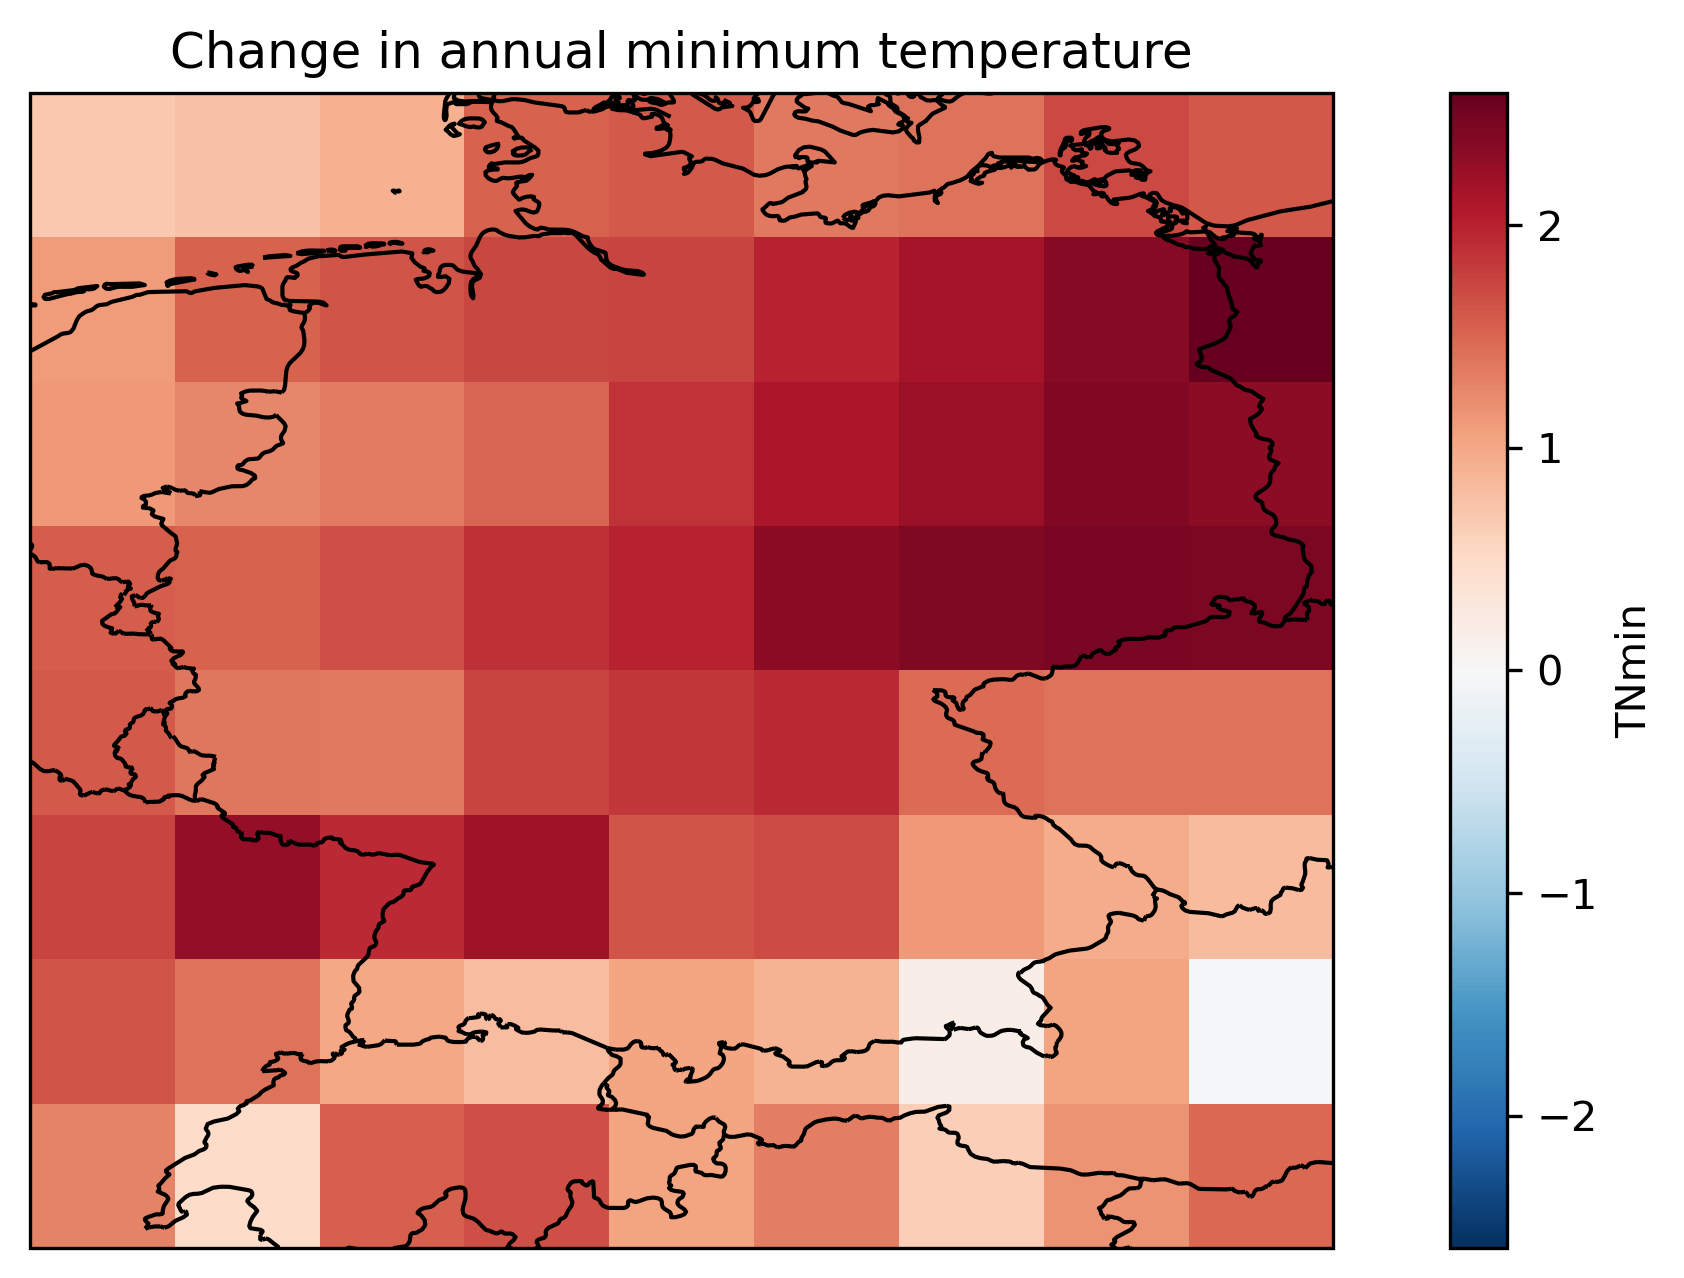

In [ ]:
ds = xr.open_dataset(save_folder+'TNmin_'+area_name+'_'+model_scenario_name+'.nc')
data = ds.TNmin
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cFeature.BORDERS)
ax.set_title("Change in annual minimum temperature")
plt.show()
fig.clear()

ds = xr.open_dataset(save_folder+'TXmax_'+area_name+'_'+model_scenario_name+'.nc')
data = ds.TXmax
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cFeature.BORDERS)
ax.set_title("Change in annual maximum temperature")

# Calculate temperature indices using daily mean temperatures

In [5]:
def Tmin(da):
    # Calculate annual minimum temperature
    # Input: daily mean temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_minimum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                Tmin = min(da_i.values)

                annual_minimum_temperatures[lat, lon, year] = Tmin - 273.15
    
    return annual_minimum_temperatures

def Tmax(da):
    # Calculate annual maximum temperature
    # Input: daily mean temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_maximum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                Tmax = max(da_i.values)

                annual_maximum_temperatures[lat, lon, year] = Tmax - 273.15
    
    return annual_maximum_temperatures


In [10]:
# Define dataset specifics

model_scenario_name = 'MRI-ESM2-0_ssp245' # Choose a model and SSP scenario
downscaled = True
area_name = 'norway' # Choose an area

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'NorESM2-LM_ssp245':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'MRI-ESM2-0_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'MPI-ESM1-2-LR_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    cooling_year = '2040-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'GFDL-ESM4_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    cooling_year = '2040-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'europe':
    southern_lat = 35; northern_lat = 72
    western_lon = 310; eastern_lon = 33  
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

if downscaled==True:
    data_folder = '../NASA_data/' # Folder where downloaded downscaled CMIP6 data is stored
else:
    data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
print(data_folder)
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load daily mean temperature data

files = glob.glob(data_folder+'tas_day_'+model_scenario_name+'*')
files.sort()
tas = xr.open_mfdataset(files)

if area_name == 'europe':
    temp1 = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, 360), 
                        time=slice(start_time, end_time))
    temp2 = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(0, eastern_lon), 
                        time=slice(start_time, end_time))

    temp = xr.concat([temp1, temp2], dim='lon')
else:
    temp = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))
temp.load()


../NASA_data/


<xarray.DataArray 'tas' (time: 16437, lat: 60, lon: 122)> Size: 481MB
array([[[      nan,       nan,       nan, ..., 247.88992, 247.93744,
         247.70593],
        [      nan,       nan,       nan, ..., 248.211  , 247.71135,
         247.5026 ],
        [      nan,       nan,       nan, ..., 248.52707, 247.96399,
         247.40233],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 249.19215, 249.43033,
         248.99487],
        [      nan,       nan,       nan, ..., 249.37262, 248.99478,
         248.52052],
        [      nan,       nan,       nan, ..., 249.54797, 249.03763,
         248.14882],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 269.90652, 270.07748,
         269.98706],
        [      nan,       nan,       nan, ..., 270.46887, 270.09814,
         270.0303 ],
        [      nan,       nan,       nan, ..., 271.02625, 270.59753,
         270.17664],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 131kB 2015-01-01T12:00:00 ... 2060-01-01T1...
  * lat      (lat) float64 480B 57.12 57.38 57.62 57.88 ... 71.38 71.62 71.88
  * lon      (lon) float64 976B 2.625 2.875 3.125 3.375 ... 32.38 32.62 32.88
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    original_name:  TA
    comment:        near-surface (usually, 2 meter) air temperature; derived ...
    units:          K
    long_name:      Daily Near-Surface Air Temperature
    standard_name:  air_temperature

In [11]:
# Choose which variable to calculate

variable_name_list = ['Tmin', 'Tmax']
unit_list = ['Celsius', 'Celsius']
description_list = ['Annual minimum temperature', 'Annual maximum temperature']

input_values_list = [temp, temp]
index_function_list = [Tmin, Tmax]


# Save data as netcdf file

for variable_name, unit, description, input_values, index_function in zip(variable_name_list, unit_list, description_list, input_values_list, index_function_list):
    print(variable_name)
    values = index_function(input_values)
    
    ds = xr.Dataset(
        data_vars=dict(
            variable=(["lat", "lon", "time"], values)
        ),
        coords=dict(
            lat=input_values.lat.values,
            lon=input_values.lon.values,
            time=time_array,
        ),
    )

    ds.time.attrs['units'] = 'year'
    ds.lat.attrs['description'] = 'latitude'
    ds.lon.attrs['description'] = 'longitude'
    ds = ds.rename_vars(dict(variable=variable_name))
    ds[variable_name].attrs['units'] = unit
    ds[variable_name].attrs['description'] = description

    if downscaled == True:
        ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'_downscaled.nc')
    else:
        ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
    print('Dataset saved')

Tmin
Dataset saved
Tmax
Dataset saved
